# CSCI-UA 0480-042 Computer Vision
## Homework 2

Enter your name and NetID below.

#### Name: Riya Singh
#### NetID: rs6854

The main goals of this assignment include:

1. Giving an introduction to PyTorch
2. Loading images using PyTorch DataLoader
3. Performing Inference on a Pretrained Resnet-18 model using a small dataset
4. Doing some analysis on the classification results
5. Reconstructing a pytorch model from onnx file
6. Build synthetic dataset - Synthesize face mask data from a dataset

There are (**10 questions in total**). Please give your answers in the space provided. In most of the questions, you will be asked to complete a code snippet. You can quickly navigate to those questions by searching (Ctrl/Cmd-F) for `TODO:`. For questions requiring a markdown answer, navigate to them by searching `Answer`.

In this homework, we'll be covering few basic PyTorch concepts. More will be covered in the next homework.

# 1. Introduction to PyTorch

[PyTorch](https://pytorch.org/) and [TensorFlow](https://www.tensorflow.org/) are open source machine learning frameworks that are used to develop and train neural network models. PyTorch is primarily developed by Facebook AI Research lab (FAIR), whereas TensorFlow is developed by the Google Brain team. You can read more about the differences between PyTorch and Tensorflow from these 2 articles:

1. [Real Python blog post by Ray Johns, "PyTorch vs TensorFlow for Your Python Deep Learning Project"](https://realpython.com/pytorch-vs-tensorflow/)

2. [Towards Data Science article by Kirill Dubovikov, "PyTorch vs TensorFlow — spotting the difference"](https://towardsdatascience.com/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b) 

In this course, we will use PyTorch.

A neural network consists of several layers. Each layer takes an input array, computes a linear product, applies some non linear activation function to give an output. These inputs and outputs are just n-dimensional arrays, and are called as `Tensor`s in PyTorch. These are similar to what we have in `NumPy` except that `Tensor`s can run on GPUs. PyTorch provides several functions for operating on these `Tensor`s. In the background, during forward and backward propagation, `Tensor`s can keep track of the computational graph and its weights' gradients. 

We'll now show how one can build a neural network in PyTorch using a simple example. \[Credits: [Deep Learning with PyTorch: A 60 Minute Blitz by Soumith Chintala](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#neural-networks)\]

Consider this network for classifying digit images:

![Neural Network Architecture for classifying digit images](./mnist.png)

This network can be built in PyTorch using the `torch.nn` package. `torch.nn` implements various neural network layers (full-connected, convolution, pooling, etc.), and activation functions (softmax, sigmoid, etc.).

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# nn.Module is a container that's used as the base class for
# building any network. It has built-in methods for loading parameters
# from a pretrained network, exporting weights from a network, moving
# the model from CPU to GPU, etc.

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Docs: 
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Docs:
        # https://pytorch.org/docs/stable/nn.functional.html#max-pool2d
        # https://pytorch.org/docs/stable/tensor_view.html#tensor-view-doc
        # https://pytorch.org/docs/stable/nn.functional.html#relu
        
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

`nn.Module` subclass requires us to fill in 3 methods:

1. `__init__`: Calls the base constructor, and instantiates all the network layers (ones that have trainable parameters).
2. `forward`: Defines the computation flow for forward propagation/inference by specifying a chain of operations. Given an input Tensor `x`, it computes output from one layer, feeds it to the next, and so on, till the final output \[i.e. the digit class (0-9) the image belongs to\] is computed. 
3. `num_flat_features`: Just a helper method used by `forward()`. This method does some shape calculation on the output from the 2nd `max_pool2d` layer, which is then used to generate a view from the `max_pool2d` layer's output. Views are used to reshape an existing Tensor without creating a new data copy, thus allowing us to do operations on Tensors faster.

You can read more from [this PyTorch tutorial on Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). First 2 sections (_Neural Networks_ and _Define the network_) are enough. We will not cover backprop/autograd in this homework -- that'll be discussed in the next homework.

With the network class defined, let's instantiate the network and print the layers inside it.

In [5]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# 2. Loading images using Dataloaders

As you've read in the above PyTorch tutorial, we can compute the output of a network on an image by calling `net()` on its tensor. This will return an output `Tensor`, with one value for each of the 10 classes. The network's predicted label for this image would be the label corresponding to the index with the highest value. 

Consider this example below. An image of size \[1, 32, 32\] is randomly generated and is fed into the network to get its label. The output is a tensor containing 10 `float` values. 

In [6]:
# Use a random 32x32 input
# 1st dimension = 1 refers to batch size = 1 (only one example/image in this batch of examples)
# 2nd dimension = 1 refers to the number of input channels = 1 (this is a BW image)
input_tensor = torch.randn(1, 1, 32, 32)
#print(input_tensor)

# Do inference on this example
output_tensor = net(input_tensor)
print(output_tensor)

tensor([[ 0.0581,  0.0048,  0.0361, -0.1518, -0.0730, -0.0319,  0.0153, -0.0558,
          0.0213, -0.0558]], grad_fn=<AddmmBackward0>)


In [7]:
print("The predicted class index of the random image is", output_tensor.argmax().numpy())

# argmax -> returns the index of the maximum value in the output_tensor
# numpy -> converts a PyTorch Tensor into a Numpy array

The predicted class index of the random image is 0


However, this approach (of calling the network on the input tensor to get its output) doesn't scale well. Typically, during the training phase, one would shuffle all the images in a dataset, load a batch of images from the shuffle, preprocess all the images in that batch (by applying some transformations such as random cropping, rescaling the image, etc.), and then provide the resulting image tensor to the model. If we simply do all these operations by iterating over the dataset using a `for` loop, these operations can turn out to be inefficient, especially when working on large datasets. For every batch, we have to generate the input tensor, and only after this step is complete, the network will be able to compute the output on this tensor.

To avoid this problem, we use a PyTorch utility called `DataLoader`, which is capable of performing all the above operations using `multiprocessing` workers (i.e. multiple threads). By delegating these tasks to separate workers,  these workers can fetch the next batch while training on the previous batch is still in progress, thereby reducing the batch generation bottleneck. In other words, the training process doesn't need to wait for the worker threads to fetch the batch for training. Furthermore, this is necessary because loading all the images in a dataset into memory and then processing them may not always be feasible because of memory constraints.

`DataLoader` takes as input a `Dataset` object, which is a PyTorch abstract class for holding and operating on a dataset. This also provides a homogenous way of working with different datasets.

[`torchvision.datasets`](https://pytorch.org/vision/0.8/datasets.html#) package provides some commonly used CV-related datasets such as [`MNIST`](http://yann.lecun.com/exdb/mnist/), [`CIFAR10`](https://www.cs.toronto.edu/~kriz/cifar.html), [`Places365`](http://places2.csail.mit.edu/index.html), etc. 

Using `Dataset` and `DataLoader`, here's how the dataloading phase in a PyTorch program works:

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Transforms refer to a set of operations one would apply to each 
# image before sending it to the network. For example, all images 
# in the dataset may not be of the same size, in which case, we could 
# use a transform to scale the image to a given size. 
# PyTorch provides a variety of transforms:
# https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose([
    transforms.ToTensor(), # first, convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

# We're telling MNIST dataset is in the folder "./mnist"
# If it doesn't exist in the folder, we're allowing the package 
# to download it (by setting download=True)
mnist = datasets.MNIST('./mnist', download=True, transform=transform)

# We don't want to use all the 60000 training images in MNIST.
# Instead we'll just use a subset of the training set (64 images)
# to make the computation faster
mnist = Subset(mnist, range(64))

# DataLoader requires a Dataset object.
# Each call to dataloader will return a batch of 16 images
# Batches are generated after shuffling the dataset
dataloader = DataLoader(mnist, batch_size=16, shuffle=True)
#print(dataloader)
# Typically one would want to train using a GPU.
# To be able to do that, torch needs to locate/access the GPU.
# cuda = torch.device("cuda") # use "cuda:0", "cuda:1" instead to use the first and second GPU respectively

#for batch_idx, (inputs, targets) in enumerate(dataloader):
    #print("Batch Idx", batch_idx, "; Input size", inputs.shape, "; Target size", targets.shape)
    

Each batch has 16 images as we've specified in the `DataLoader`. Each target has 16 values, where each value is the index of the true label the image belongs to. The 2nd dimension in the `inputs` tensor refers to the number of input channels, which is 1 in this case, because MNIST contains BW images. 3rd and 4th dimension refer to the image's height and width respectively.

Also check out this [thread](https://twitter.com/_ScottCondron/status/1363494433715552259) \[yes, it's a tweet :)\] and [this article](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel).

# 3. Inference on the sample Imagenet dataset

To demonstrate inference on a pretrained network, we've created a dataset, consisting of 100 images by sampling 5 images from 20 classes in the Imagenet dataset. Imagenet dataset comprises approximately 1 million images and 1000 classes, and in the interest of keeping things simple, we've provided a smaller subset. 

## Question 1 [15%]
To work with this dataset, you'll need to create a `Dataset` object, since Imagenet dataset cannot be downloaded directly via the `torchvision.datasets` package. In order to do that, you need to define a class subclassing the abstract `Dataset` class. Any custom `Dataset` class should contain the following:

1. `__init__()` method: Constructor method. We've provided the list of attributes the class would need.
2. `__len__()` method: Returns the number of samples in the dataset.
3. `__getitem__()` method: Given an index, it returns the (input, target) pair at that index.

In [9]:
from torch.utils.data import Dataset
import glob
import numpy as np
from PIL import Image

class SampleImagenetDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        '''
        Args:
        root_dir: path where all the 100 jpg images are located
        transform: set of transforms to apply on a dataset sample
        '''
        # TODO: Generate a list containing paths to all the 100 jpg images inside
        # dataset_dir folder location passed as an argument. Use the glob library to do this.
        dataset_dir = '../shared/data/HW2/imagenet_samples/*.jpg'
        self.image_list = glob.glob(dataset_dir)
        
        # TODO: There's a file called 'labels_to_ids.txt' inside the dataset_dir.
        # Read the file contents to generate a dictionary containing
        # label to idx mapping. The resulting dictionary should have a `str`
        # type key mapped to a `int` type value representing the index
        
        with open ('../shared/data/HW2/imagenet_samples/labels_to_ids.txt', 'r') as file: 
            lines = file.readlines() 
            self.labels_to_ids = {}
            for line in lines: 
                self.labels_to_ids[line.split()[0]] = int(line.split()[1])

        self.transform = transform
    
        print(self.labels_to_ids) 
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_path = self.image_list[idx]

        classname = img_path.split("_", 3)[-1].split(".")[0]
        label = self.labels_to_ids[classname]
        
        # TODO: Open the image using PIL.Image package
        image = Image.open(img_path)
        
        if self.transform:
            # TODO: Apply the transform to the `image` which is the parameter for 
            # this(SampleImagenetDataset) class and overwrite the output back to the `image` variable
            image = self.transform(image)
        
        return image, label
    
#SampleImagenetDataset(Dataset)


## Question 2 [5%]
Having defined our custom dataset class, we'll instantiate a `SampleImagenetDataset` class object. And then we'll set up a `DataLoader` object.

In [10]:
from torchvision import transforms

data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

sample_dataset = SampleImagenetDataset('../shared/data/HW2/imagenet_samples', data_transform)

# TODO: Create a `DataLoader` object
# to load images from `sample_dataset` object created above.
# Shuffle the dataset and use a batch size of 10.
# Docs: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
dataset_loader = DataLoader(sample_dataset, batch_size=10, shuffle=True)
#print(dataset_loader)

{'iPod': 605, 'orange': 950, 'lemon': 951, 'fig': 952, 'ski': 795, 'trombone': 875, 'jellyfish': 107, 'hammer': 587, 'purse': 748, 'pomegranate': 957, 'banjo': 420, 'guacamole': 924, 'snowmobile': 802, 'stove': 827, 'zebra': 340, 'strawberry': 949, 'crutch': 523, 'dishwasher': 534, 'digital_clock': 530, 'dumbbell': 543}


## Question 3 [5%]
Using the `DataLoader` object, we will iterate over the dataset, dividing it into batches and working on each batch per iteration. For each batch, the network takes the input tensor and outputs the prediction. All predictions and targets (true labels) will be combined and stored in 2 lists -- `outputs` and `targets` respectively.

In [11]:
from torchvision import models

# TODO:
# Construct a **pretrained** ResNet-18 model. Use the
# `torchvision.models` package.
resnet18 = models.resnet18(pretrained=True)

outputs = []
targets = []

for idx, (input_tensor, target_tensor) in enumerate(dataset_loader):
    # TODO: Compute the pretrained model's output on input_tensor
    output_tensor = resnet18(input_tensor)
    
    # Notes:
    # 1. Using argmax() gives the index of the maximum value in the output_tensor 
    #    This is the network's predicted label. output_tensor is a 2d tensor of 
    #    dimensions [batch_size, num_classes]. argmax(axis=1) returns the indices 
    #    of the maximum values across dim=1 (across the row). Resulting tensor 
    #    would be a 1D tensor of size [batch_size].
    #    See https://pytorch.org/docs/stable/generated/torch.argmax.html#torch-argmax
    # 2. Calling numpy() converts a PyTorch tensor to a numpy array
    # 3. list(<arr>) converts a NumPy array to a list
    # 4. l1 += l2 appends elements of list l2 to list l1.
    
    outputs += list(output_tensor.argmax(1).numpy())
    targets += list(target_tensor.numpy())
#print("Batch Idx", idx, "; Input size", input_tensor.shape, "; Target size", target_tensor.shape, "; Output Size", output_tensor.shape)
print(outputs,'\n')
print(targets)

#Each batch has 16 images as we've specified in the DataLoader. 
#Each target has 16 values, where each value is the index of the true 
#label the image belongs to. The 2nd dimension in the inputs tensor refers 
#to the number of input channels, which is 1 in this case, because MNIST 
#contains BW images. 3rd and 4th dimension refer to the image's height 
#and width respectively.



[594, 710, 523, 921, 571, 107, 666, 957, 940, 530, 924, 951, 949, 496, 710, 205, 586, 543, 530, 802, 523, 827, 676, 744, 748, 420, 145, 473, 530, 957, 107, 748, 420, 802, 450, 831, 594, 949, 534, 481, 218, 107, 340, 804, 924, 951, 957, 561, 795, 862, 412, 860, 875, 970, 523, 534, 125, 949, 597, 598, 996, 950, 949, 534, 827, 961, 340, 542, 952, 949, 340, 952, 802, 5, 827, 875, 943, 543, 950, 677, 486, 107, 516, 523, 957, 340, 587, 951, 340, 446, 523, 562, 924, 423, 957, 651, 420, 632, 957, 951] 

[523, 530, 523, 795, 530, 107, 952, 957, 951, 530, 924, 951, 949, 605, 587, 534, 605, 543, 530, 802, 523, 827, 748, 587, 748, 420, 587, 748, 530, 951, 107, 748, 420, 802, 802, 543, 875, 949, 534, 875, 950, 107, 340, 420, 924, 950, 957, 795, 795, 795, 827, 802, 875, 795, 523, 534, 924, 949, 748, 605, 952, 950, 949, 534, 827, 924, 340, 420, 952, 949, 340, 952, 802, 107, 827, 875, 951, 543, 950, 952, 875, 107, 587, 523, 957, 340, 587, 950, 340, 605, 543, 827, 924, 543, 957, 534, 420, 605, 957, 951

## Question 4 [5%]
How many batches are generated in the `for` loop? What're the sizes/shapes of the `input_tensor`, `target_tensor` and `output_tensor` in any given iteration?

#### Answer :
Number of Batches : 10 <br> 
Size of input_tensor : [10, 3, 224, 224] <br>
Size of target_tensor : [10] <br> 
Size of output_tensor : [10, 1000] <br> 


# 4. Classification Analysis

From part 3, we have the network's predicted label indices and the target label (or the true label) indices. Using [`scikit-learn`](https://machinelearningmastery.com/a-gentle-introduction-to-scikit-learn-a-python-machine-learning-library/), we'll perform some analysis on those results. 

But before we do that, we'll convert those `int`-type indices to `str`-type labels using a idx-to-label mapping. This mapping has been provided in the `../shared/data/HW2/imagenet_samples` folder in a file named `ids_to_labels.txt`. 

## Question 5 [5%]
Read the contents of the file and generate a python dictionary that holds the idx-to-label mapping. In the map, the key is an `int`-type index and the value is a `str`-type label.

In [12]:
# TODO:
label_file = "../shared/data/HW2/imagenet_samples/ids_to_labels.txt"

#ids_to_labels_lines = open(label_file, 'r').readlines()
#ids_to_labels = {int(line.split()[0]): line.split()[1] for line in ids_to_labels_lines}

with open (label_file, 'r') as file: 
    lines = file.readlines() 
    ids_to_labels = {}
    for line in lines: 
        ids_to_labels[int(line.split()[0])] = line.split()[1]
        
# We'll convert the list of keys in the mapping to a Python `set`
ids = set(ids_to_labels.keys())
print(ids_to_labels)
#print(ids)

{605: 'iPod', 950: 'orange', 951: 'lemon', 952: 'fig', 795: 'ski', 875: 'trombone', 107: 'jellyfish', 587: 'hammer', 748: 'purse', 957: 'pomegranate', 420: 'banjo', 924: 'guacamole', 802: 'snowmobile', 827: 'stove', 340: 'zebra', 949: 'strawberry', 523: 'crutch', 534: 'dishwasher', 530: 'digital_clock', 543: 'dumbbell'}


Now let's convert these `int`-values in the `outputs` list to a list of `str`-type labels. However, some network predictions may not be in the list of classes we've picked (remember: Imagenet has 1000 classes and we just picked 20 classes). Such indices will be mapped to label "other" using the method below:

In [13]:
def transform_outputs(outputs):
    return [ids_to_labels[output] if output in ids else "other" for output in outputs]

outputs = transform_outputs(outputs)
print(outputs, '\n')
targets = transform_outputs(targets)
print(targets)





['other', 'other', 'crutch', 'other', 'other', 'jellyfish', 'other', 'pomegranate', 'other', 'digital_clock', 'guacamole', 'lemon', 'strawberry', 'other', 'other', 'other', 'other', 'dumbbell', 'digital_clock', 'snowmobile', 'crutch', 'stove', 'other', 'other', 'purse', 'banjo', 'other', 'other', 'digital_clock', 'pomegranate', 'jellyfish', 'purse', 'banjo', 'snowmobile', 'other', 'other', 'other', 'strawberry', 'dishwasher', 'other', 'other', 'jellyfish', 'zebra', 'other', 'guacamole', 'lemon', 'pomegranate', 'other', 'ski', 'other', 'other', 'other', 'trombone', 'other', 'crutch', 'dishwasher', 'other', 'strawberry', 'other', 'other', 'other', 'orange', 'strawberry', 'dishwasher', 'stove', 'other', 'zebra', 'other', 'fig', 'strawberry', 'zebra', 'fig', 'snowmobile', 'other', 'stove', 'trombone', 'other', 'dumbbell', 'orange', 'other', 'other', 'jellyfish', 'other', 'crutch', 'pomegranate', 'zebra', 'hammer', 'lemon', 'zebra', 'other', 'crutch', 'other', 'guacamole', 'other', 'pomegra

## Question 6 [5%]
Using [`sklearn.metrics`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) generate a classification report showing the per-class precision, recall and f1-score. 


In [14]:
from sklearn import metrics

# TODO: Check classification_report method here https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(metrics.classification_report(targets, outputs, digits=3))


               precision    recall  f1-score   support

        banjo      1.000     0.600     0.750         5
       crutch      0.800     0.800     0.800         5
digital_clock      1.000     0.600     0.750         5
   dishwasher      1.000     0.600     0.750         5
     dumbbell      1.000     0.400     0.571         5
          fig      1.000     0.400     0.571         5
    guacamole      1.000     0.600     0.750         5
       hammer      1.000     0.200     0.333         5
         iPod      0.000     0.000     0.000         5
    jellyfish      1.000     0.800     0.889         5
        lemon      0.500     0.400     0.444         5
       orange      1.000     0.400     0.571         5
        other      0.000     0.000     0.000         0
  pomegranate      0.833     1.000     0.909         5
        purse      1.000     0.400     0.571         5
          ski      1.000     0.200     0.333         5
   snowmobile      1.000     0.600     0.750         5
        s

/opt/conda/envs/csciua-0480042-fall/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/csciua-0480042-fall/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/csciua-0480042-fall/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Question 7 [5%]
In 3-4 sentences, explain what micro- and macro- averages are and how they're different from each other. The method used in Q6 above does not print the micro-averaged metrics, please briefly explain why in 3-4 lines.


#### Answer : 

Macro-average computes the standard average of all classes and assumes an equal contribution of each class, i.e., the number of items in each class is about the same. Micro-average computes more of a weighted average of the classes by considering the number of items in each class. Micro-average may be a better metric when the classes are imbalanced and the number of items in each class vary significantly. <br>
The method in Q6 doesn't print the micro-averaged metrics because it doesn't consider the number of items in each class that the output correctly predicts. It assumes that each class correctly predicts the same number of items, like in the target list where there are 5 items of each class. If we were to consider the imbalance in the number of items predicted for each class, then that would compute the micro-average. 


## Question 8 [5%]

A confusion matrix (or an error matrix) allows us to visualize model's performance on a per-class basis. From [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix), "each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class (or vice versa)".

Using `sklearn.metrics`, compute the confusion matrix.

In [15]:
ids_to_labels[0] = "other"
labels_list = list(ids_to_labels.values())

# TODO: Search for a method in sklearn.metrics package which gives you the required matrix : https://scikit-learn.org/stable/modules/classes.html#classification-metrics
conf_matrix = metrics.confusion_matrix(targets, outputs, labels=labels_list)

Now let's plot the confusion matrix:

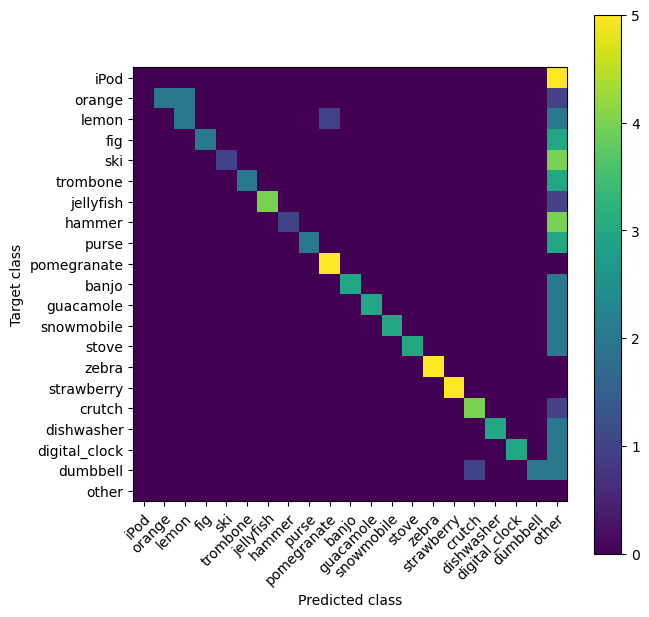

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(7, 7))
plot = ax.imshow(conf_matrix, interpolation="nearest")
ax.set_xticks(np.arange(0, 21))
ax.set_xticklabels(labels_list)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(np.arange(0, 21))
ax.set_yticklabels(labels_list);
ax.set_xlabel("Predicted class")
ax.set_ylabel("Target class")
plt.colorbar(plot, ax=ax);

## Note : Before proceeding further, please restart the kernel without clearing output to free up memory and start fresh for next questions.

# 5. Reconstructing a model from onnx file


## Question 9 [25%]

Your task is to reconstruct a pytorch model from the onnx file “reconstruct.onnx” (located in your current HW2 directory) and print the model summary at the end. You’ll have to reverse engineer what the netron notations for convolution mean from your previous assignment. <br>

Refer HW1 to create a CNN and https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html <br>
`Hint : Read and use`<a href="https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html"><u>`this`</u></a>`for the ConvTranspose layers.` <br>
`Hint : Click on the nodes of netron graph in the netron app to get the parameters for a particular node/layer.`

In [2]:
import torch 
from torch import nn
import torch.nn.functional as F
import torch.onnx
from torchsummary import summary
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        #self.network = nn.Sequential( )
        # TODO : Your model code here ...
        self.conv1 = nn.Conv2d(3, 64, kernel_size= 3, stride= 1, padding= 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size= 2, stride= 2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size= 3, stride= 1, padding= 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size= 2, stride= 2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size= 3, stride= 1, padding= 1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size= 2, stride= 2)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size= 3, stride= 1, padding= 1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size= 2, stride= 2)
        
        self.conv5 = nn.Conv2d(512, 1024, kernel_size= 3, stride= 1, padding= 1) 
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size= 2, stride= 2)
        
        self.convTr1 = nn.ConvTranspose2d(1024, 512, kernel_size= 2, stride= 2)
        self.convTr2 = nn.ConvTranspose2d(1024, 256, kernel_size= 2, stride= 2)
        self.convTr3 = nn.ConvTranspose2d(512, 128, kernel_size= 2, stride= 2)
        self.convTr4 = nn.ConvTranspose2d(256, 128, kernel_size= 2, stride= 2)
        self.convTr5 = nn.ConvTranspose2d(128, 3, kernel_size= 2, stride= 2)
    
    def forward(self, x):
        # TODO : Your model code here ...
        #y = self.network(x)
        
        # Branch 1 
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.maxpool1(y)
        
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.maxpool2(y)

        # Store Branch 1  
        branch1 = y 
        
        # Branch 2  
        y = self.conv3(y)
        y = self.relu3(y)
        y = self.maxpool3(y)

        # Store Branch 2
        branch2 = y 
        
        # Branch 3 
        y = self.conv4(y)
        y = self.relu4(y)
        y = self.maxpool4(y)
        
        # Store Branch 3  
        branch3 = y
        
        # Branch 4 
        y = self.conv5(y) 
        y = self.relu5(y) 
        y = self.maxpool5(y)
        y = self.convTr1(y) 
        
        #Combine branch 3 and 4 
        y = torch.cat((y, branch3), dim= 1) 
        y = self.convTr2(y)
        
        #Combine branch 2, 3, 4 
        y = torch.cat((y, branch2), dim= 1)
        y = self.convTr3(y)
        
        #Combine all branches 
        y = torch.cat((y, branch1), dim= 1) 
        
        y = self.convTr4(y)
        y = self.convTr5(y)
        
        return y   
#net = ConvNet()
#print(net)      

Simulate a RGB 256x256 image to feed forward the network and generate a onnx model file, you can use the netron app(https://netron.app/) to check if the model you created is same as asked("reconstruct.onnx").

`Note : You can ignore the warnings.`

In [3]:
x = torch.randn(1, 3, 256, 256, requires_grad=True)
model = ConvNet()
output = model(x)
torch.onnx.export(model, # model being run
                  x,     # model input (or a tuple for multiple inputs)
                  "myconvnet.onnx",
                  do_constant_folding=True,
                  dynamic_axes={'input' : {0 : 'batch_size'},'output' : {0 : 'batch_size'}}
                 )

/opt/conda/envs/csciua-0480042-fall/lib/python3.7/site-packages/torch/onnx/utils.py:1516: UserWarning: Provided key input for dynamic axes is not a valid input/output name
  key
/opt/conda/envs/csciua-0480042-fall/lib/python3.7/site-packages/torch/onnx/utils.py:1516: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  key


Print model summary by running on a RGB 256x256 placeholder

In [4]:
model = ConvNet()
print(summary(model, (3, 256, 256)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
         MaxPool2d-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
              ReLU-5        [-1, 128, 128, 128]               0
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
              ReLU-8          [-1, 256, 64, 64]               0
         MaxPool2d-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 512, 32, 32]       1,180,160
             ReLU-11          [-1, 512, 32, 32]               0
        MaxPool2d-12          [-1, 512, 16, 16]               0
           Conv2d-13         [-1, 1024, 16, 16]       4,719,616
             ReLU-14         [-1, 1024,

# 6. Synthesize face mask data from a dataset

## Question 10 [25%]

We now want to work with a face detection dataset (Widerface : http://shuoyang1213.me/WIDERFACE/) but as a face segmentation problem. The issue is that Widerface dataset does not have segmentation maps as annotations, only bounding box annotations. Your task is to synthesize the segmentation masks using the bounding box annotations.
<br>
The file `annotations.txt` located in the shared folder `../shared/data/HW2/wider_face/annotations.txt` has annotations for images located at `../shared/data/HW2/wider_face/images`, it is a subset of 6 images of WiderFace dataset. <br>
The first task is to read the annotations file and generate a map with key being the file/image name and the values being the annotations for each image.

The structure/format of annotation.txt file is as follows :

< image 1 > <br>
< number of faces in image 1 = m_1 > <br>
< face 1 > <br>
< face 2 > <br>
...<br>
< face m_1 > <br>
.<br>
.<br>
.<br>
< image n > <br>
< number of faces in image n = m_n > <br>
< face 1 > <br>
< face 2 > <br>
...<br>
< face m_n > <br>

Each placeholder for a face in above format has 10 integers. We are only interested in the first four integers that specify the location of a face. The first 4 integers specify the location of a face in the image `(top_left_x, top_left_y, width_of_face, height_of_face)`

In [5]:
def get_annotations_map(annotation_file_path):
    annotation_file = open(annotation_file_path).read()
    lines = annotation_file.splitlines() 
    image_annotations = {}
    
    for i in range(len(lines)): 
        if lines[i].endswith('.jpg'):
            image_name_line = lines[i] 
            image_name = image_name_line.split()[0]
            number_of_faces = int(lines[i+1])
            annotations = []
            for j in range(number_of_faces):  
                annotation = lines[i+2+j].split()
                top_left_x, top_left_y, width_of_face, height_of_face = annotation[0:4]
                annotations.append([int(top_left_x),
                                int(top_left_y),
                                int(width_of_face),
                                int(height_of_face)
                                ])
            image_annotations[image_name] = annotations
        else: 
            continue 
    return image_annotations

#print(get_annotations_map("../shared/data/HW2/wider_face/annotations.txt"))

Run below cell to visualize the images specified in the annotations.txt file.

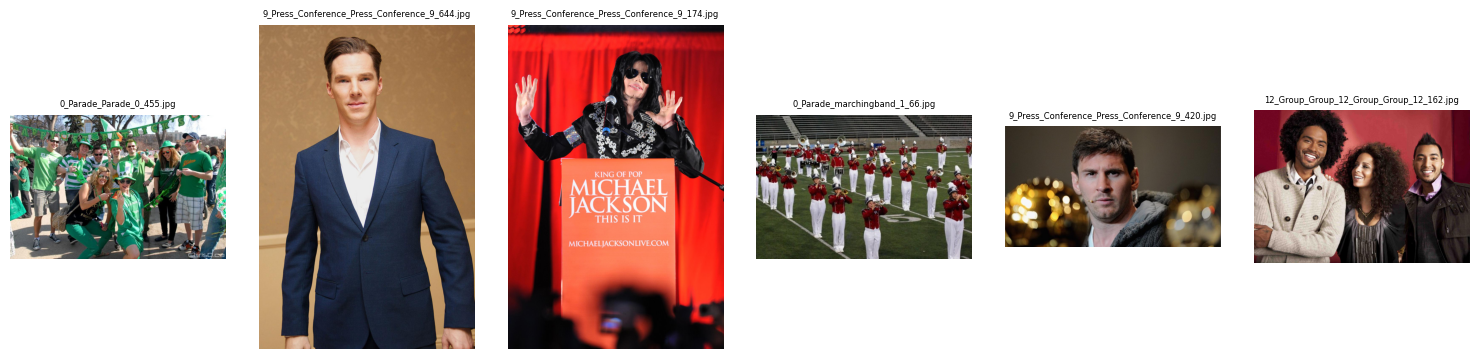

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams.update({'font.size': 5})
annotation_file = "../shared/data/HW2/wider_face/annotations.txt"
image_annotations = get_annotations_map(annotation_file)
images = image_annotations.keys()
fig, ax = plt.subplots(1,len(images), figsize=(15, 15))
fig.tight_layout()

col = 0
for image in images:
    img_path = "../shared/data/HW2/wider_face/images/" + str(image)
    label = image
    ax[col].imshow(Image.open(img_path))
    ax[col].set_title(label)
    ax[col].axis('off')
    col = col + 1

The next task is to generate a masked image for an input image. The masked image will have the faces highlighted as shown here in the image.<br><br> ![mask_image_sample.png](./mask_image_sample.png) <br>

The function `is_outside_shape` takes in the shape of mask (`rectangle` or `circle` or `ellipse`), the center pixel location of face, width_of_face, height_of_face and a candidate mask pixel location(point). `is_outside_shape` should return true if a candidate mask pixel location(point) is outside the bounds of the input shape given the center, false otherwise.


The function `datagen` takes in input file name , the annotations associated with it and the shape of the mask to be generated(for example for the above image the shape of the mask is a rectangle). <br> 
`datagen` function will generate a mask-highlighted image from the input and save it in your current directory. 
<br>
<br>
Read throught the comments and fill in the `TODO:` marked spaces to complete the definition of the functions. We use a flood fill(kind of DFS) approach with the seed being the center of the face to mark the mask pixels and then overlay the masks on the input image to produce the desired result.

In [7]:
import cv2
import math

def is_outside_shape(shape, center, width, height, point):
    # center location of face
    cx,cy = center
    
    # candidate mask point
    tx,ty = point
    
    if(shape == 'rectangle'):
        # TODO : Write code to return true if point is inside the bounds of the rectangle centered at (cx,cy)
        if tx < (cx + width/2) and tx > (cx - width/2):
            if ty < (cy + height/2) and ty > (cy - height/2): 
                return False

    if(shape == 'circle'):
        # TODO : Write code to return true if point is inside the bounds of the circle centered at (cx,cy)
        if (pow((tx - cx),2) + pow((ty-cy), 2)) <= pow((width/2), 2): 
            return False 

    if(shape == 'ellipse'):
        # TODO : Write code to return true if point is inside the bounds of the ellipse centered at (cx,cy) 
         if (((pow((tx - cx), 2))/pow((width/2), 2) + (pow((ty - cy), 2)/pow((height/2), 2))) <= 1):
            return False 
    
    return True
      
    
def datagen(img_file_name, annotations, mask_shape):
    img = cv2.imread(img_file_name)
    
    # TODO : Create an empty mask image with same dimentions as the input image
    label = np.zeros((img.shape[0], img.shape[1]))
    
    for annotation in annotations:
        # TODO : Get the location (top_left_x, top_left_y, width_of_face, height_of_face) of face
        # from annotation in a single line - using unpacking in Python
        top_left_x, top_left_y, width_of_face, height_of_face = annotation
        
        # TODO : Compute the center point of the face - this will be the seed of the flood fill
        #cx,cy = (top_left_x + (width_of_face/2) - (height_of_face/2)), (top_left_y + (width_of_face/2) - (height_of_face/2))
        cx,cy = ((top_left_x + (width_of_face/2)), (top_left_y + (height_of_face/2)))
        
        # We create a queue to take account of all candidate mask pixels(neighbours of a mask pixel) 
        # and initialize with the center point of face which we know for sure sould be a mask pixel
        queue = [(cx, cy)]
        
        neighbors = [(0,1),(0,-1),(1,0),(-1,0)]
        
        while(queue):
            # pop out a candidate mask pixel
            tx, ty = queue.pop(0)
            tx = int(tx)
            ty = int(ty)
            
            # TODO : check if pixel is already marked or if it is outside the mask shape
            if(label[ty,tx] >= 1 or is_outside_shape(mask_shape, (cx, cy), width_of_face, height_of_face, (tx,ty))):
                # No need to fill this value - because outside the bounds of the shape or its already been filled
                continue 
                
            # mark the pixel; we'll multiply the mask by 255 for visualization
            label[ty,tx] = 1 
            
            # push to queue all the neighboring pixels of the candidate pixel (tx,ty)
            for i,j in neighbors:
                x = tx + i
                y = ty + j
                # check for ignoring out of bounds pixels
                if(0<=x<img.shape[1] and 0<=y<img.shape[0]):
                    queue.append((x,y))
    
    # Create a 3 channel image with same height and width as the input image
    label_ = np.zeros((img.shape[0],img.shape[1],3),dtype= np.uint8)
    
    # Fill the 3 channel image with mask
    label_[:,:,0] = label
    label_[:,:,1] = label
    label_[:,:,2] = label
    
    # Output file name for the masked image
    output_image_path = "./results/" + img_file_name.split('/')[-1].split(".")[0] + "_" + mask_shape +"_masked.jpg"
    
    # Highlight the masked area of the image
    dst = cv2.addWeighted(img[ :, :, ::-1 ],0.5,label_*255,0.7,0)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    # TODO : Write the highlighted output image(dst) at output_image_path
    cv2.imwrite(output_image_path, dst)
    
    return output_image_path

Run below cell to produce and visualize the masked images. For each input image the results will look similar to below image :
![mask_sample_all_shapes.png](./mask_sample_all_shapes.png)

(You don't have to change anything in the cell below. Just run it to get the results)

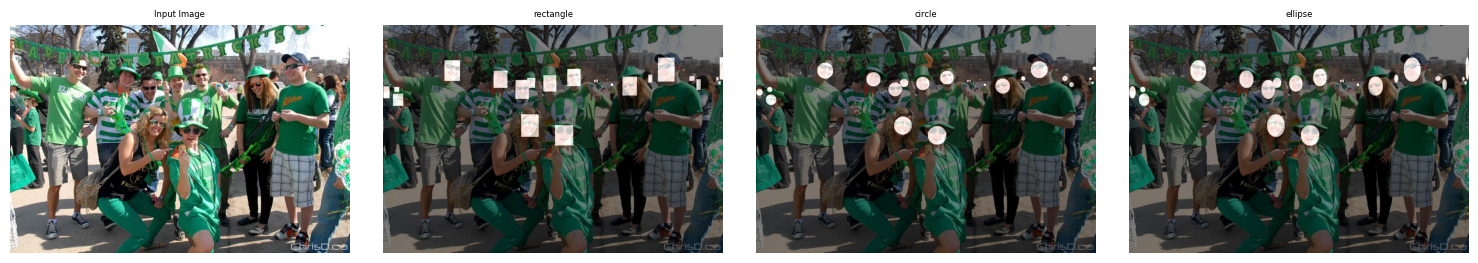

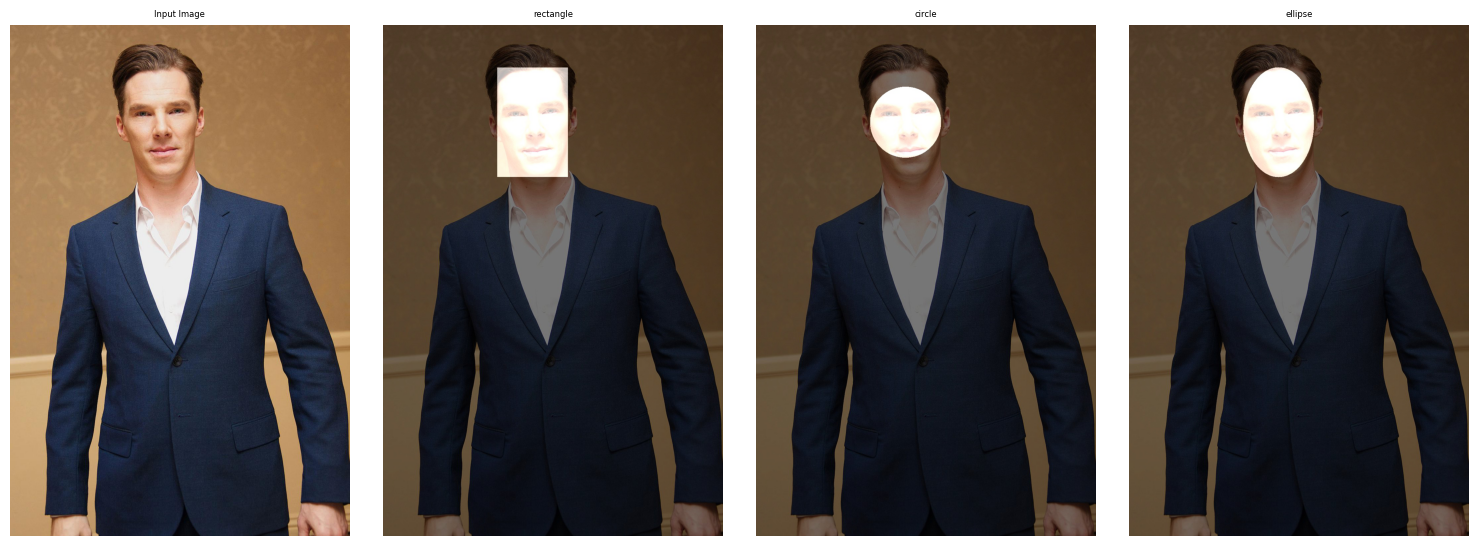

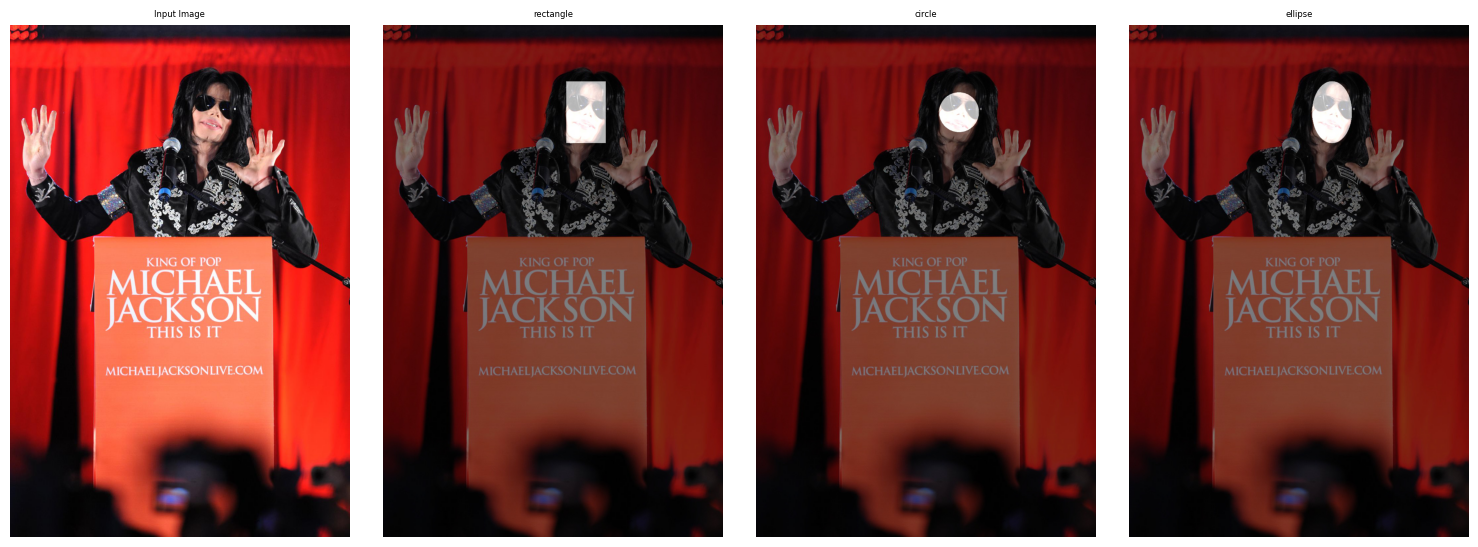

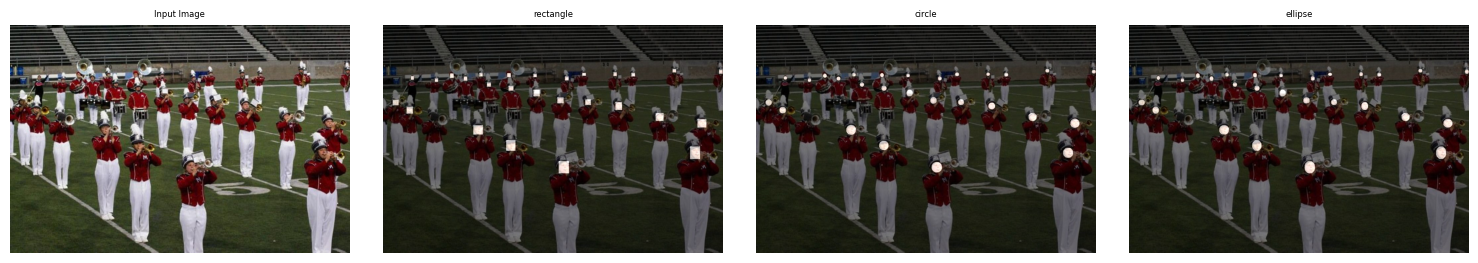

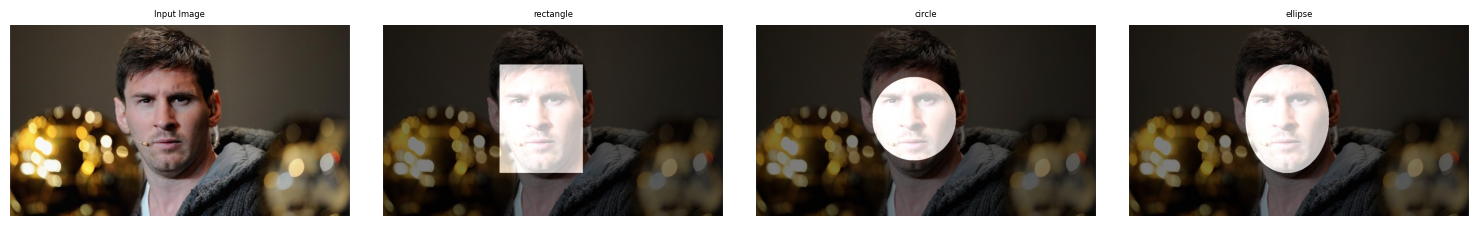

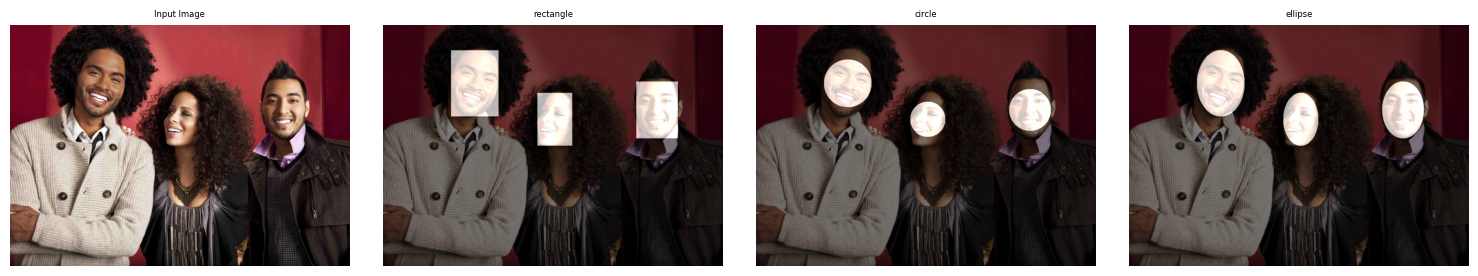

In [8]:
import matplotlib.image as mpimg
import cv2
import numpy as np
import math
from PIL import Image


mask_shapes = ['rectangle', 'circle', 'ellipse']
for image in image_annotations.keys():
    image_name = "../shared/data/HW2/wider_face/images/" + image
    img = mpimg.imread(image_name)
    
    fig, ax = plt.subplots(1,len(mask_shapes) + 1, figsize=(15, 15))
    fig.tight_layout()
    col = 0
    label = "Input Image"
    ax[col].imshow(img)
    ax[col].set_title(label)
    ax[col].axis('off')
    col = col + 1
    
    for shape in mask_shapes :
        output_image = datagen(image_name,image_annotations[image], shape)
        img = mpimg.imread(output_image)
        ax[col].imshow(img)
        ax[col].set_title(shape)
        ax[col].axis('off')
        col = col + 1
        